## Generate Data

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(10)

dim = 2
n_centers = 20
n_classes = 2 # 0 or 1
n_centers_per_class = n_centers // n_classes
variance = 1/5
std_dev = np.sqrt(variance)
prior = 0.5 # likelihood y=0 == likelihood y=1

x_means = np.random.normal(0, std_dev, n_centers)  # Means for x coordinates
y_means = np.random.normal(0, std_dev, n_centers)  # Means for y coordinates

centers = np.array(list(zip(x_means, y_means)))
centers = centers.reshape(n_classes,n_centers_per_class,dim)
print(centers)

ModuleNotFoundError: No module named 'pandas'

In [16]:
def generate_data_points(centers, n_samples, std_dev):
    data = []
    for center in centers:
        x_samples = np.random.normal(center[0], std_dev, n_samples)
        y_samples = np.random.normal(center[1], std_dev, n_samples)
        samples = np.column_stack((x_samples, y_samples))
        data.append(samples)
    return np.vstack(data)

def generate_data_matrices(centers, sample_size):
    n_classes = centers.shape[0]
    n_centers_per_class = centers.shape[1]
    n_samples_per_center = (sample_size // n_classes) // n_centers_per_class
    
    Xtrain = []
    Ytrain = []
    for target, class_centers in enumerate(centers):
        X = generate_data_points(class_centers, n_samples_per_center, std_dev)
        Y = [target] * X.shape[0]
        Xtrain.append(X)
        Ytrain.append(Y)
    
    Xtrain = np.vstack(Xtrain)
    Ytrain = np.concatenate(Ytrain)
    return Xtrain, Ytrain

Xtrain, Ytrain = generate_data_matrices(centers, 200)
Xtest, Ytest = generate_data_matrices(centers, 10000)

print(f"Xtrain: {Xtrain.shape}")
print(f"Ytrain: {Ytrain.shape}")
print(f"Xtest: {Xtest.shape}")
print(f"Ytest: {Ytest.shape}")

Xtrain: (200, 2)
Ytrain: (200,)
Xtest: (10000, 2)
Ytest: (10000,)


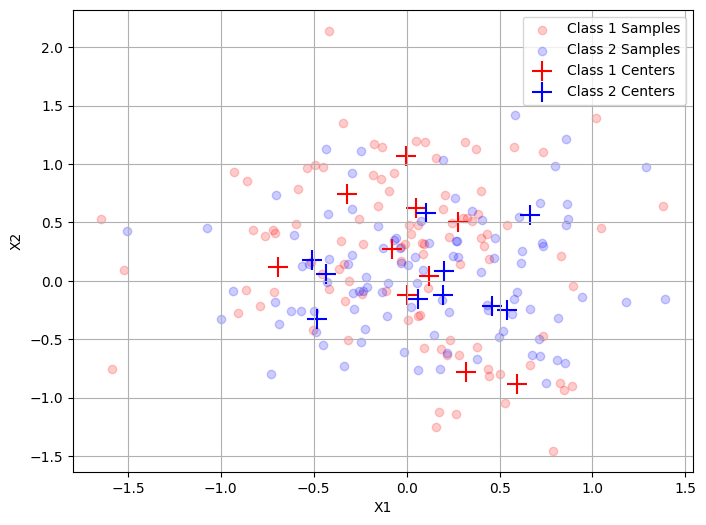

In [17]:
plt.figure(figsize=(8, 6))

n_samples_per_class = Xtrain.shape[0] // n_classes

plt.scatter(Xtrain[:n_samples_per_class, 0], Xtrain[:n_samples_per_class, 1], color='red', alpha=0.2, label='Class 1 Samples')
plt.scatter(Xtrain[n_samples_per_class:, 0], Xtrain[n_samples_per_class:, 1], color='blue', alpha=0.2, label='Class 2 Samples')

# plot the centers with a '+' marker
plt.scatter(centers[0,:,0], centers[0,:,1], color='red', marker='+', s=200, label='Class 1 Centers')
plt.scatter(centers[1,:,0], centers[1,:,1], color='blue', marker='+', s=200, label='Class 2 Centers')

plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()


## Bayes

In [29]:
import numpy as np

# Identity covariance matrix (since you are not using any covariance info, assuming it's an identity matrix)
cov_matrix = np.eye(2)
cov_inv = np.linalg.inv(cov_matrix)
cov_det = np.linalg.det(cov_matrix)

def gaussian_likelihood(X, center):
    """
    Compute Gaussian likelihood
    Args:
        X: matrix of feature data with shape (n_samples, n_features)
        center: 
    """
    diff = X - center
    exponent = -0.5 * np.einsum('ij,ij->i', diff @ cov_inv, diff)
    normalization = 1 / np.sqrt((2 * np.pi)**dim * cov_det)
    return normalization * np.exp(exponent)

# Compute the likelihood for all centers of a given class
def compute_likelihood(X, centers):
    """
    Compute likelihood for all centers of a given class
    """
    likelihood = np.zeros((X.shape[0], centers.shape[0]))
    for i, center in enumerate(centers):
        likelihood[:, i] = gaussian_likelihood(X, center)
    return likelihood.sum(axis=1)

likelihood_class_0 = compute_likelihood(Xtest, centers[0])
likelihood_class_1 = compute_likelihood(Xtest, centers[1])

posterior_class_0 = likelihood_class_0 * prior
posterior_class_1 = likelihood_class_1 * prior

# normalize posteriors
total_posterior = posterior_class_0 + posterior_class_1
posterior_class_0 /= total_posterior
posterior_class_1 /= total_posterior

Ypred = np.where(posterior_class_0 > posterior_class_1, 0, 1)

In [30]:
predicted_index = pd.MultiIndex.from_tuples([('predicted', 'p'),('predicted', 'n')])
actual_index = pd.MultiIndex.from_tuples([('actual', 'p'),('actual', 'n')])

pd.DataFrame(confusion_matrix(Ytest, Ypred), index=predicted_index, columns=actual_index)

actual      
                 p     n
predicted p   1717  3283
          n    787  4213